In [1]:
import pandas
import numpy as np

In [2]:
raw = pandas.read_excel('filtered_data.xlsx')
raw.columns

Index(['Last Name', 'First Name', 'Position', 'GP', 'G', 'A', 'A1', 'PTS',
       '+/-', 'IPP%', 'TOI/GP', 'iCF', 'iFF', 'iSF', 'iSCF', 'iHDCF', 'iRush',
       'iReb', 'Pass', 'ZS%', 'iGVA', 'iTKA', 'iBLK', 'S.Bkhd', 'S.Dflct',
       'S.Slap', 'S.Snap', 'S.Tip', 'S.Wrap', 'S.Wrst', 'CF', 'CA', 'FF', 'FA',
       'SF', 'SA', 'Ht', 'Wt', 'Age', 'PIM'],
      dtype='object')

In [3]:
player_names = raw['First Name'].values + ' ' + raw['Last Name'].values
raw = raw.drop(columns=['First Name', 'Last Name'])

targets_goals = raw['G'].values.reshape(-1,1).astype(dtype = 'float32')
targets_assists = raw['A'].values.reshape(-1,1).astype(dtype = 'float32')
targets_primary_assists = raw['A1'].values.reshape(-1,1).astype(dtype = 'float32')
targets_points = raw['PTS'].values.reshape(-1,1).astype(dtype = 'float32')
targets_plusminus = raw['+/-'].values.reshape(-1,1).astype(dtype = 'float32')
raw = raw.drop(columns = ['G', 'A', 'A1','PTS', '+/-'])

In [4]:
for i,position in enumerate(raw['Position']):
    if position in ['C/RW', 'LW/C', 'LW/RW', 'RW/C', 'LW', 'RW']:
        raw['Position'][i] = 'W'
one_hot_position = pandas.get_dummies(raw['Position'])
raw = raw.drop(columns = ['Position'])

D:\Programmes\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
def shuffle_data(*sets):
    rng_state = np.random.get_state()
    for set in sets:
        np.random.set_state(rng_state)
        np.random.shuffle(set)

In [6]:
data = np.concatenate((one_hot_position, raw.values), axis=1).astype(dtype = 'float32')
shuffle_data(player_names, targets_goals, targets_assists, targets_primary_assists, targets_plusminus, targets_points, data)

In [7]:
train_size = int(data.shape[0] * 0.70)
valid_size = int(data.shape[0] * 0.10)
split = np.array([train_size+valid_size])

In [8]:
#Separate training and test sets
training_player_names, test_player_names = np.split(player_names, split)
training_targets_goal, test_targets_goals = np.split(targets_goals, split)
training_targets_assists, test_targets_assists = np.split(targets_assists, split)
training_targets_primary_assists, test_targets_primary_assists = np.split(targets_primary_assists, split)
training_targets_plusminus, test_targets_plusminus = np.split(targets_plusminus, split)
training_targets_points, test_targets_points = np.split(targets_points, split)
training_data, test_data = np.split(data, split)

In [9]:
print(training_data.shape)

(712, 35)


## Implémentation Random Forest et Baye's Ridge

In [10]:
# vérifier que sklearn est bien installé en exécutant cette cellule
import sklearn
import matplotlib.pyplot as plt

In [11]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import LinearSVR,SVR

In [12]:
classifiers = [
    ('Random Forests', RandomForestRegressor()),
    ("Bayesian Ridge Regression",BayesianRidge()),
    ("Support Vector Regression",LinearSVR(dual=False,loss="squared_epsilon_insensitive"))
]

to_predict = [
    (training_targets_goal, test_targets_goals,"Goals"),
    (training_targets_assists, test_targets_assists,"Assists"),
    (training_targets_primary_assists, test_targets_primary_assists,"Primary Assists"),
    (training_targets_plusminus, test_targets_plusminus,"Plus/Minus"),
    (training_targets_points, test_targets_points,"Points")
]

D:\Programmes\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


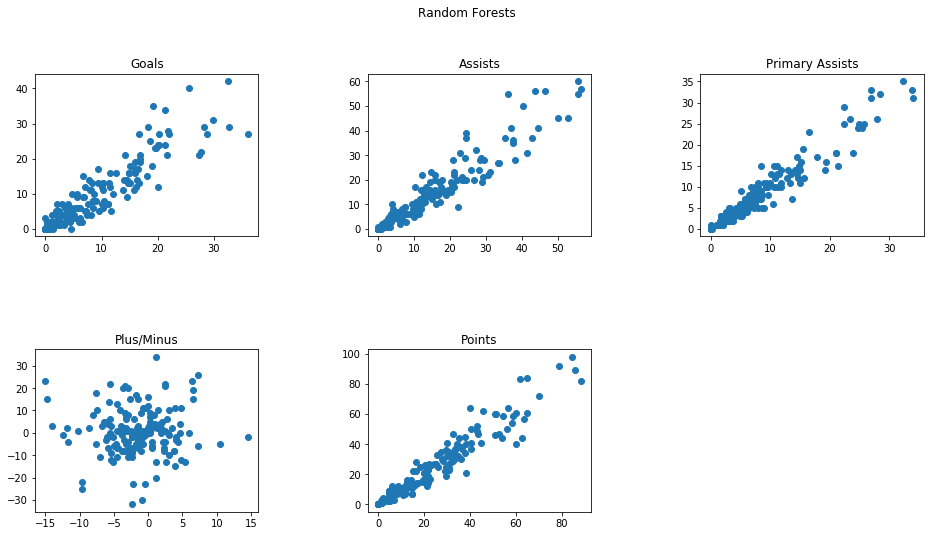

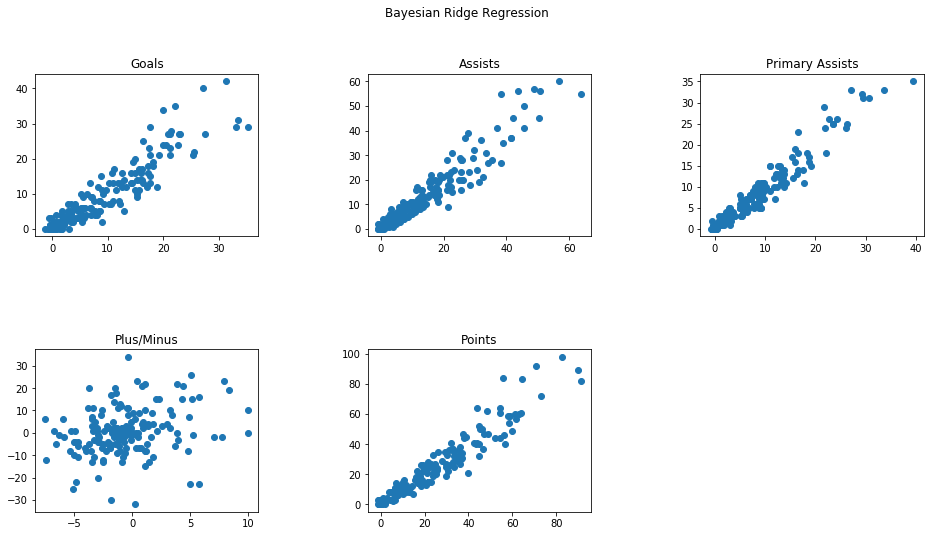

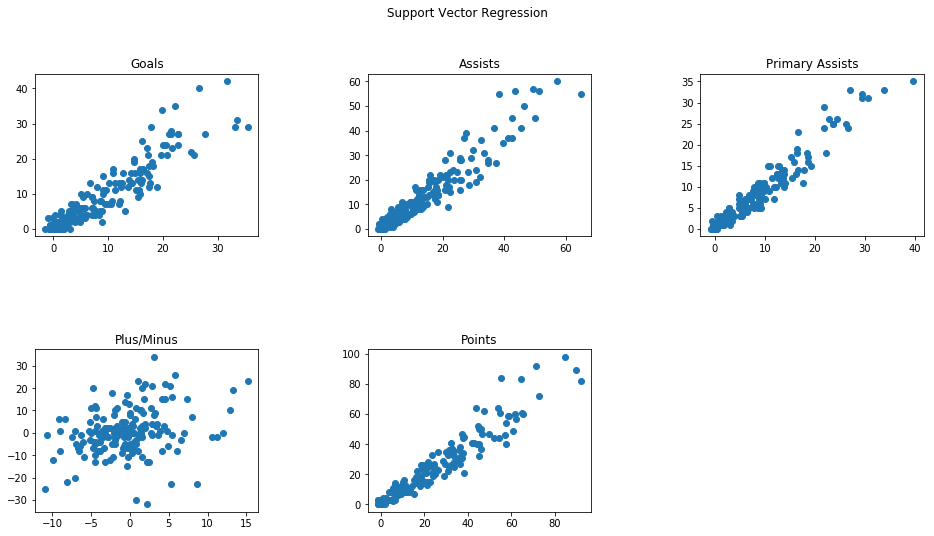

In [13]:
figure=0
for model_name, model_instance in classifiers:
    figure += 1
    plt.figure(figure,figsize=(15,20))
    plt.suptitle(model_name)
    i=0
    for target,to_print,name in to_predict:
        i+=1
        classifier = model_instance
        classifier.fit(training_data, target.ravel())
        
        plt.subplot(5,3,i)
        plt.scatter(classifier.predict(test_data),to_print)
        plt.title(name)
        
    plt.tight_layout(pad=8)
    plt.show()

## Exploring different kernels with SVR:

In [14]:
SVR_classifiers=[
    ("Linear SVR C=1", LinearSVR(dual=False,loss="squared_epsilon_insensitive")),
    ("Linear SVR C=100", LinearSVR(dual=False,loss="squared_epsilon_insensitive")),
    ("Basic case",LinearSVR(max_iter=20000))
#    ("RBF SVR", SVR(kernel="rbf",tol=1e-4,gamma='auto'))     stupid
]

Linear SVR C=1-->Goals
Linear SVR C=1-->Assists
Linear SVR C=1-->Primary Assists
Linear SVR C=1-->Plus/Minus
Linear SVR C=1-->Points
Linear SVR C=100-->Goals
Linear SVR C=100-->Assists
Linear SVR C=100-->Primary Assists
Linear SVR C=100-->Plus/Minus
Linear SVR C=100-->Points


D:\Programmes\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Basic case-->Goals


D:\Programmes\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Basic case-->Assists


D:\Programmes\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Basic case-->Primary Assists


D:\Programmes\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Basic case-->Plus/Minus
Basic case-->Points


D:\Programmes\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


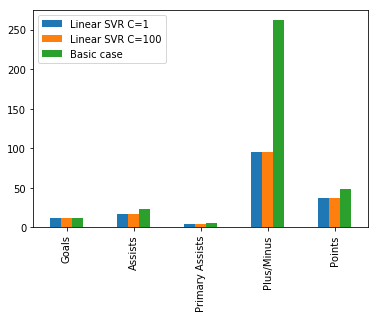

In [15]:
Lin_svr_err1=[]
Lin_svr_err2=[]
Lin_svr_err3=[]
#Rbf_svr_err=[]

sq_Err=[ Lin_svr_err1,Lin_svr_err2,Lin_svr_err3]
models=[]

for (model_name, model_instance),error in zip(SVR_classifiers,sq_Err):
    models.append(model_name)
    for target, to_print, target_name in to_predict:
        classifier = model_instance
        classifier.fit(training_data, target.ravel())

        sqr_error = sklearn.metrics.mean_squared_error(to_print,classifier.predict(test_data))
        error.append(sqr_error)
        print(model_name+'-->'+target_name)
bins=[]
for i,j,name in to_predict:
    bins.append(name)
#_X=np.arange(len(bins))
    
#for to_plot,(model_name,dummy) in zip(sq_Err,SVR_classifiers):
#    plt.bar(bins,to_plot,label=model_name)
   
df = pandas.DataFrame(np.c_[Lin_svr_err1,Lin_svr_err2,Lin_svr_err3],index=bins)
df=df.rename(index=str,columns={i:j for i,j in zip(range(3),models)})
df.plot.bar()
    
#plt.legend()
plt.show()

## Exploring different kind of Random Forests and tuning.

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

In [19]:
Forest_regressors=[
    ('Random Forests', RandomForestRegressor()),
    ("Extra Tress", ExtraTreesRegressor())
]

# tuned_parameters ={"n_estimators":[5,10,25,50,75,100,150],"max_features":[6,12,18,24,30,35],'min_samples_split':[i/100 for i in range(1,9)],'bootstrap':[True,False]}
tuned_parameters ={"n_estimators":[5,10,25,50],"max_features":[6,12,18,24,30],'min_samples_split':[i/100 for i in range(1,6)],'bootstrap':[True,False]}

for model_name,model in Forest_regressors:
    print("# Tuning hyper-parameters for: "+model_name)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=4)
    clf.fit(training_data, training_targets_goal.ravel())

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Calculating mean squared error on test set with best params found")
    print()
    y_true, y_pred = test_targets_goals, clf.predict(test_data)
    print("Erreur quadratique moyenne: ", mean_squared_error(y_true, y_pred))
    print()

# Tuning hyper-parameters for: Random Forests

Best parameters set found on development set:

{'bootstrap': True, 'max_features': 30, 'min_samples_split': 0.02, 'n_estimators': 75}

Grid scores on development set:

0.845 (+/-0.072) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 5}
0.862 (+/-0.069) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 10}
0.867 (+/-0.066) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 25}
0.872 (+/-0.058) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 50}
0.869 (+/-0.065) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 75}
0.871 (+/-0.057) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 100}
0.871 (+/-0.058) for {'bootstrap': True, 'max_features': 6, 'min_samples_split': 0.01, 'n_estimators': 150}
0.847 (+/-0.069) for {'bootstrap': 

In [116]:
##Exploring different hyper-parameters for Bayesian Ridge Regression.
B_Ridge_regressors=[
    ('Bayesian Ridge Regressor', BayesianRidge())
]

tuned_parameters ={'alpha_1':[1e-7,5.5e-7,1e-6,5.5e-6,1e-5,5.5e-5],'alpha_2':[1e-7,5.5e-7,1e-6,5.5e-6,1e-5,5.5e-5],
                   'lambda_1':[1e-7,5.5e-7,1e-6,5.5e-6,1e-5,5.5e-5],'lambda_2':[1e-7,5.5e-7,1e-6,5.5e-6,1e-5,5.5e-5]}

for model_name,model in B_Ridge_regressors:
    print("# Tuning hyper-parameters for: "+model_name)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=None)
    clf.fit(training_data, training_targets_goal.ravel())

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Calculating mean squared error on test set with best params found")
    print()
    y_true, y_pred = test_targets_goals, clf.predict(test_data)
    print("Erreur quadratique moyenne: ", mean_squared_error(y_true, y_pred))
    print()

# Tuning hyper-parameters for: Bayesian Ridge Regressor

Best parameters set found on development set:

{'alpha_1': 5.5e-05, 'alpha_2': 1e-07, 'lambda_1': 1e-07, 'lambda_2': 5.5e-05}

Grid scores on development set:

0.862 (+/-0.009) for {'alpha_1': 1e-07, 'alpha_2': 1e-07, 'lambda_1': 1e-07, 'lambda_2': 1e-07}
0.862 (+/-0.009) for {'alpha_1': 1e-07, 'alpha_2': 1e-07, 'lambda_1': 1e-07, 'lambda_2': 5.5e-07}
0.862 (+/-0.009) for {'alpha_1': 1e-07, 'alpha_2': 1e-07, 'lambda_1': 1e-07, 'lambda_2': 1e-06}
0.862 (+/-0.009) for {'alpha_1': 1e-07, 'alpha_2': 1e-07, 'lambda_1': 1e-07, 'lambda_2': 5.5e-06}
0.862 (+/-0.009) for {'alpha_1': 1e-07, 'alpha_2': 1e-07, 'lambda_1': 1e-07, 'lambda_2': 1e-05}
0.862 (+/-0.009) for {'alpha_1': 1e-07, 'alpha_2': 1e-07, 'lambda_1': 1e-07, 'lambda_2': 5.5e-05}
0.862 (+/-0.009) for {'alpha_1': 1e-07, 'alpha_2': 1e-07, 'lambda_1': 5.5e-07, 'lambda_2': 1e-07}
0.862 (+/-0.009) for {'alpha_1': 1e-07, 'alpha_2': 1e-07, 'lambda_1': 5.5e-07, 'lambda_2': 5.5e-07}
0.8

Le résultat de cette exploration n'est pas surprenant puisque les paramètres alpha et lambda sont des priors sur les distributions gammas qui servent à optimiser les paramètres. Il y a donc une convergence claire du modèle ici vers des alpha et lambda "optimaux".

## Exploring Basic Ridge Regression

In [20]:
##Exploring different hyper-parameters for Basic Ridge Regression.
#On fait cette exploration ici, mais on s'attend à ce qu'elle performe moins que le Bayesian Ridge Regression

from sklearn.linear_model import Ridge

Base_Ridge_regressors=[
    ('Basic Ridge Regressor', Ridge())
]

tuned_parameters ={'alpha':[1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,5,1e1,5e1,1e2,5e2,1e3,5e3,1e4]}

for model_name,model in Base_Ridge_regressors:
    print("# Tuning hyper-parameters for: "+model_name)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=None)
    clf.fit(training_data, training_targets_goal.ravel())

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Calculating mean squared error on test set with best params found")
    print()
    y_true, y_pred = test_targets_goals, clf.predict(test_data)
    print("Erreur quadratique moyenne: ", mean_squared_error(y_true, y_pred))
    print()

# Tuning hyper-parameters for: Basic Ridge Regressor

Best parameters set found on development set:

{'alpha': 5000.0}

Grid scores on development set:

0.867 (+/-0.012) for {'alpha': 0.0001}
0.869 (+/-0.011) for {'alpha': 0.0005}
0.869 (+/-0.011) for {'alpha': 0.001}
0.869 (+/-0.011) for {'alpha': 0.005}
0.869 (+/-0.011) for {'alpha': 0.01}
0.869 (+/-0.011) for {'alpha': 0.05}
0.869 (+/-0.011) for {'alpha': 0.1}
0.869 (+/-0.011) for {'alpha': 0.5}
0.869 (+/-0.011) for {'alpha': 1}
0.869 (+/-0.010) for {'alpha': 5}
0.869 (+/-0.010) for {'alpha': 10.0}
0.869 (+/-0.010) for {'alpha': 50.0}
0.869 (+/-0.011) for {'alpha': 100.0}
0.870 (+/-0.011) for {'alpha': 500.0}
0.870 (+/-0.012) for {'alpha': 1000.0}
0.872 (+/-0.015) for {'alpha': 5000.0}
0.871 (+/-0.017) for {'alpha': 10000.0}

Calculating mean squared error on test set with best params found

Erreur quadratique moyenne:  8.846433



C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.582963e-14
  overwrite_a=True).T
C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.186558e-14
  overwrite_a=True).T
C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.218546e-13
 

## Keeping best params for retained models and plotting mean squared error on test set

Linear SVR-->Goals
Linear SVR-->Assists
Linear SVR-->Primary Assists
Linear SVR-->Plus/Minus
Linear SVR-->Points
Random Forests-->Goals
Random Forests-->Assists
Random Forests-->Primary Assists
Random Forests-->Plus/Minus
Random Forests-->Points
Extra Tress-->Goals
Extra Tress-->Assists
Extra Tress-->Primary Assists
Extra Tress-->Plus/Minus
Extra Tress-->Points
Bayesian Ridge Regressor-->Goals
Bayesian Ridge Regressor-->Assists
Bayesian Ridge Regressor-->Primary Assists
Bayesian Ridge Regressor-->Plus/Minus
Bayesian Ridge Regressor-->Points
Basic Ridge Regressor-->Goals
Basic Ridge Regressor-->Assists
Basic Ridge Regressor-->Primary Assists
Basic Ridge Regressor-->Plus/Minus
Basic Ridge Regressor-->Points


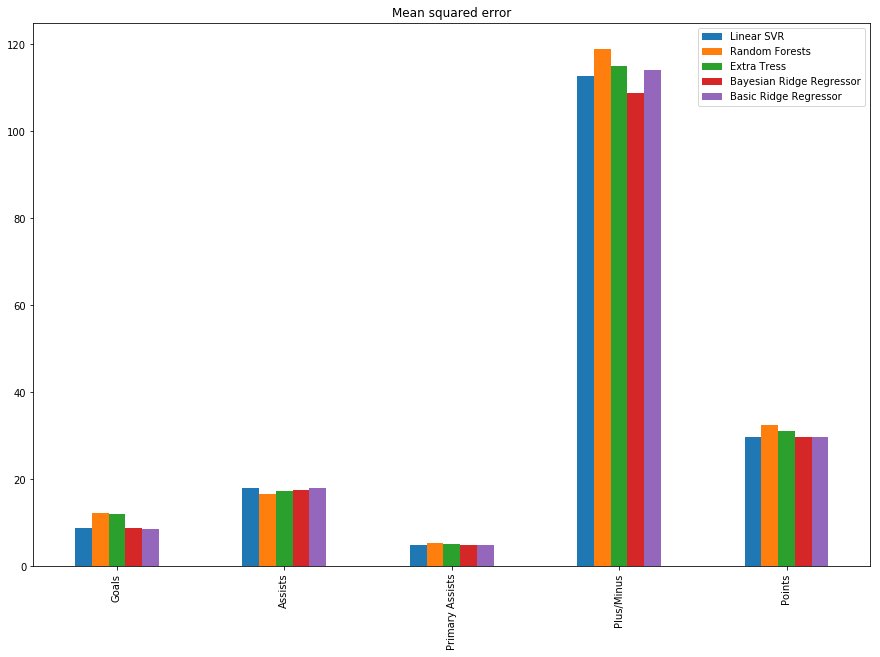

In [21]:
Retained_regressors=[
    ("Linear SVR", LinearSVR(dual=False,loss="squared_epsilon_insensitive")),
    ('Random Forests', RandomForestRegressor(bootstrap= True,max_features= 24,min_samples_split=0.02, n_estimators= 75)),
    ("Extra Trees", ExtraTreesRegressor(bootstrap= True, max_features= 35, min_samples_split=0.01, n_estimators= 25)),
    ('Bayesian Ridge Regressor', BayesianRidge()),
    ('Basic Ridge Regressor', Ridge(alpha= 1000.0))
    
]


Lin_r_err1,predict1=[],[]
Lin_r_err2,predict2=[],[]
Lin_r_err3,predict3=[],[]
Lin_r_err4,predict4=[],[]
Lin_r_err5,predict5=[],[]

sq_Err=[ Lin_r_err1,Lin_r_err2,Lin_r_err3,Lin_r_err4,Lin_r_err5]
all_predictions = [predict1,predict2,predict3,predict4,predict5]
models=[]

for (model_name, model_instance),error,predictions in zip(Retained_regressors,sq_Err,all_predictions):
    models.append(model_name)
    for target, to_print, target_name in to_predict:
        classifier = model_instance
        classifier.fit(training_data, target.ravel())

        sqr_error = sklearn.metrics.mean_squared_error(to_print,classifier.predict(test_data))
        error.append(sqr_error)
        predictions.append(classifier.predict(test_data))
        print(model_name+'-->'+target_name)
bins=[]
for i,j,name in to_predict:
    bins.append(name)
#_X=np.arange(len(bins))
    
#for to_plot,(model_name,dummy) in zip(sq_Err,SVR_classifiers):
#    plt.bar(bins,to_plot,label=model_name)


df = pandas.DataFrame(np.c_[Lin_r_err1,Lin_r_err2,Lin_r_err3,Lin_r_err4,Lin_r_err5],index=bins)
df=df.rename(index=str,columns={i:j for i,j in zip(range(5),models)})
df.plot.bar(figsize=(15,10))
    
#plt.legend()
plt.title("Mean squared error")
plt.show()

## Printing Deviations

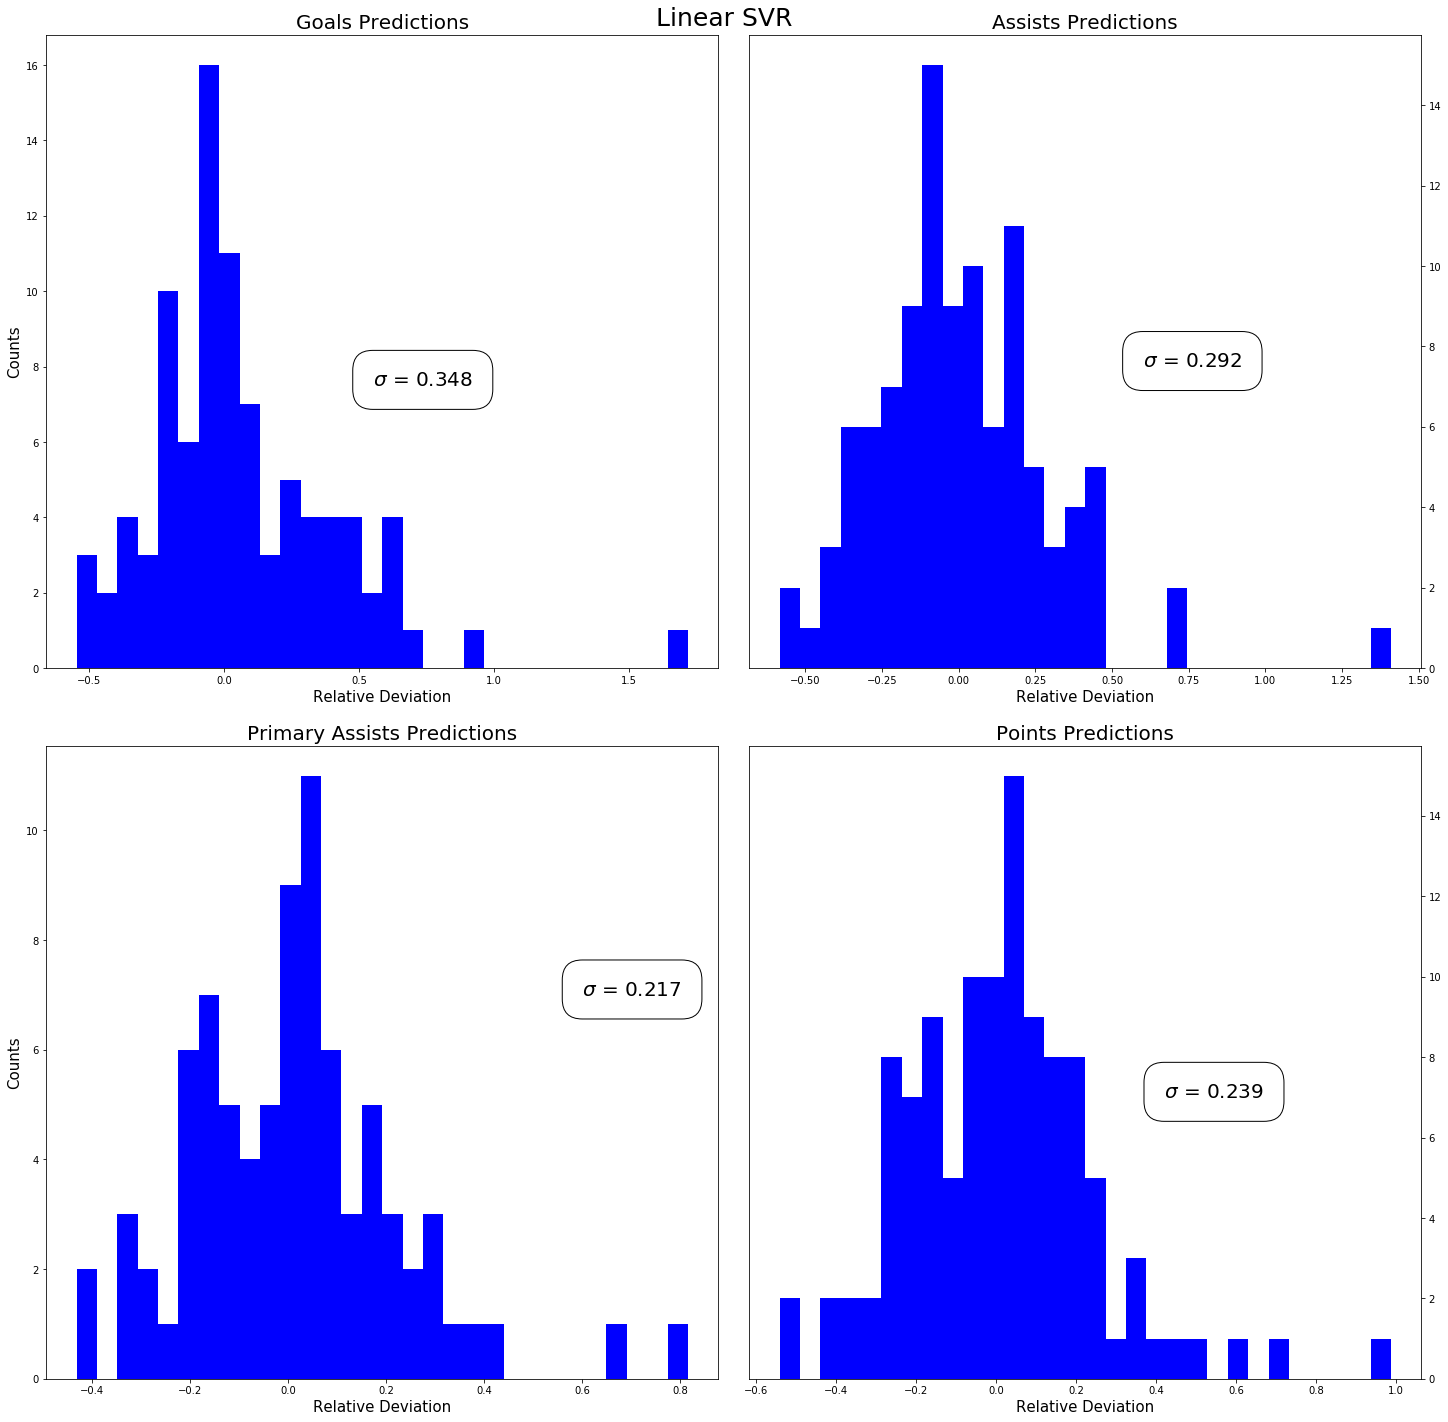

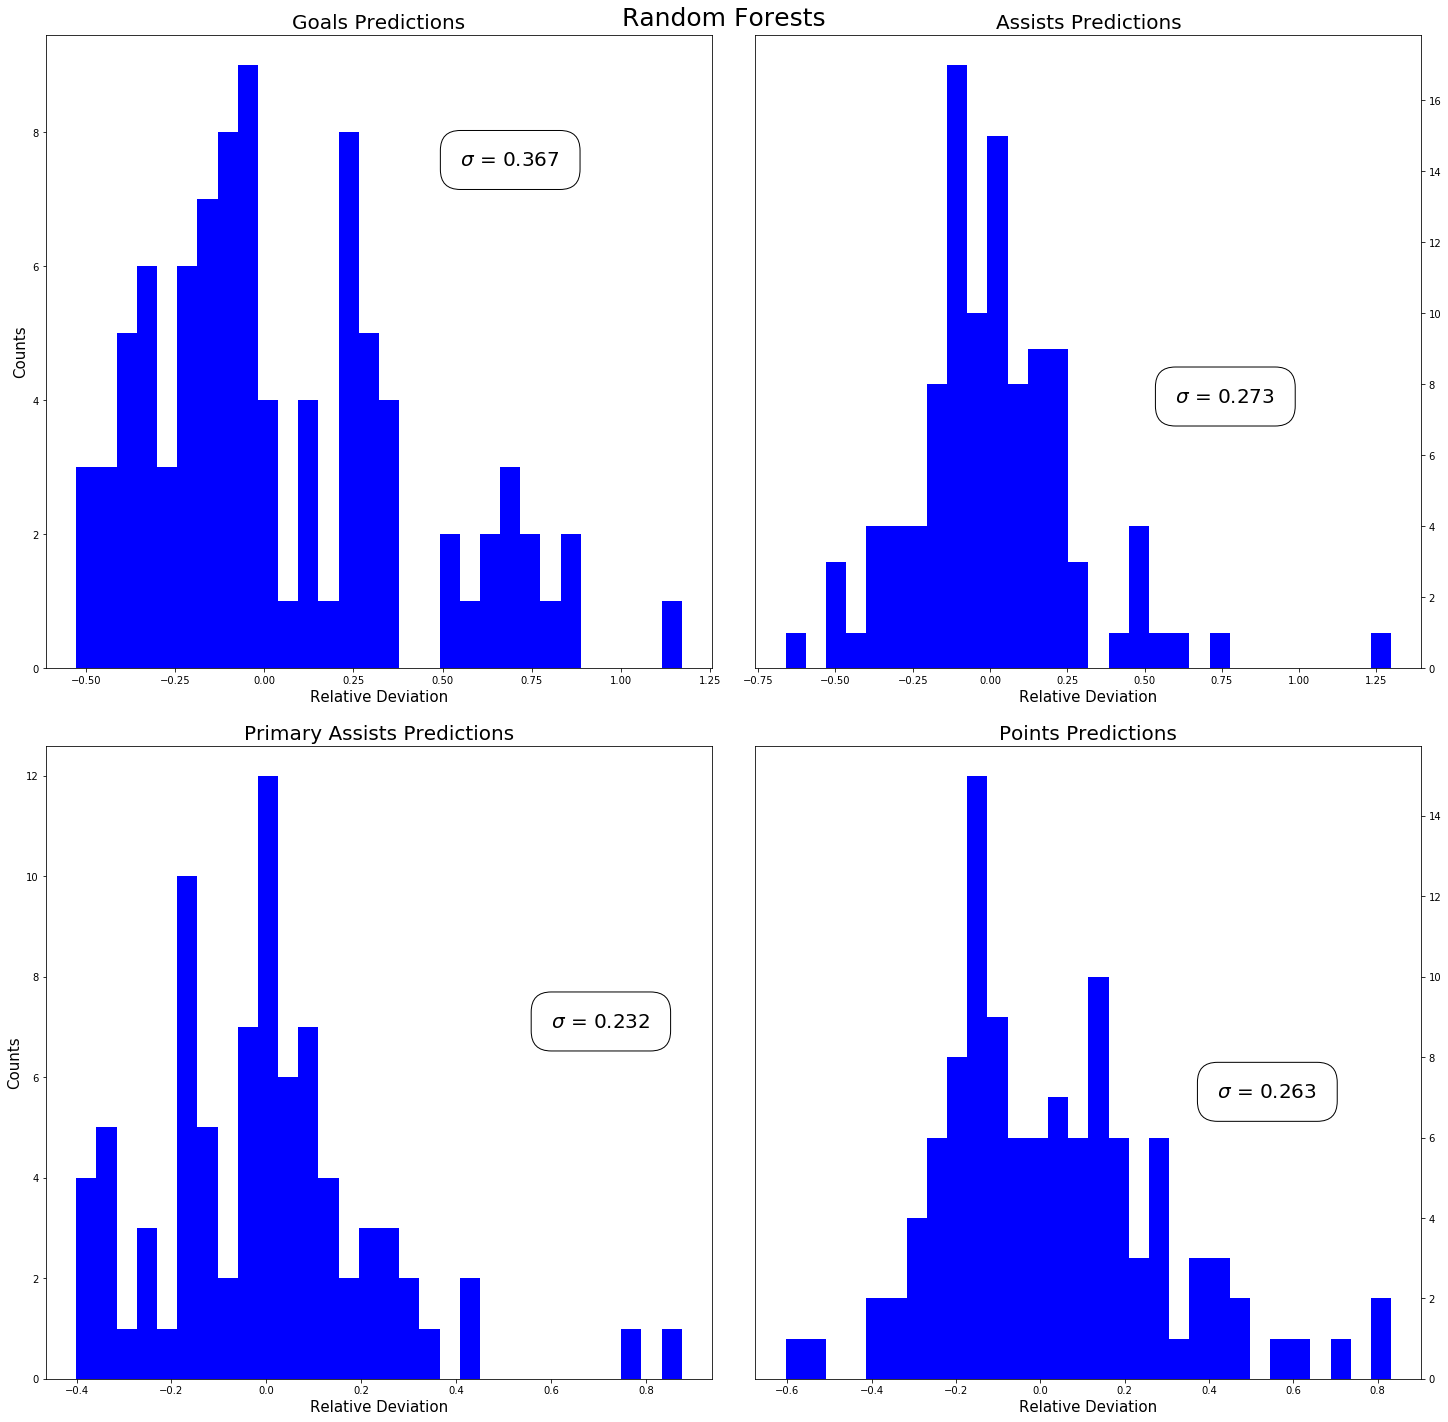

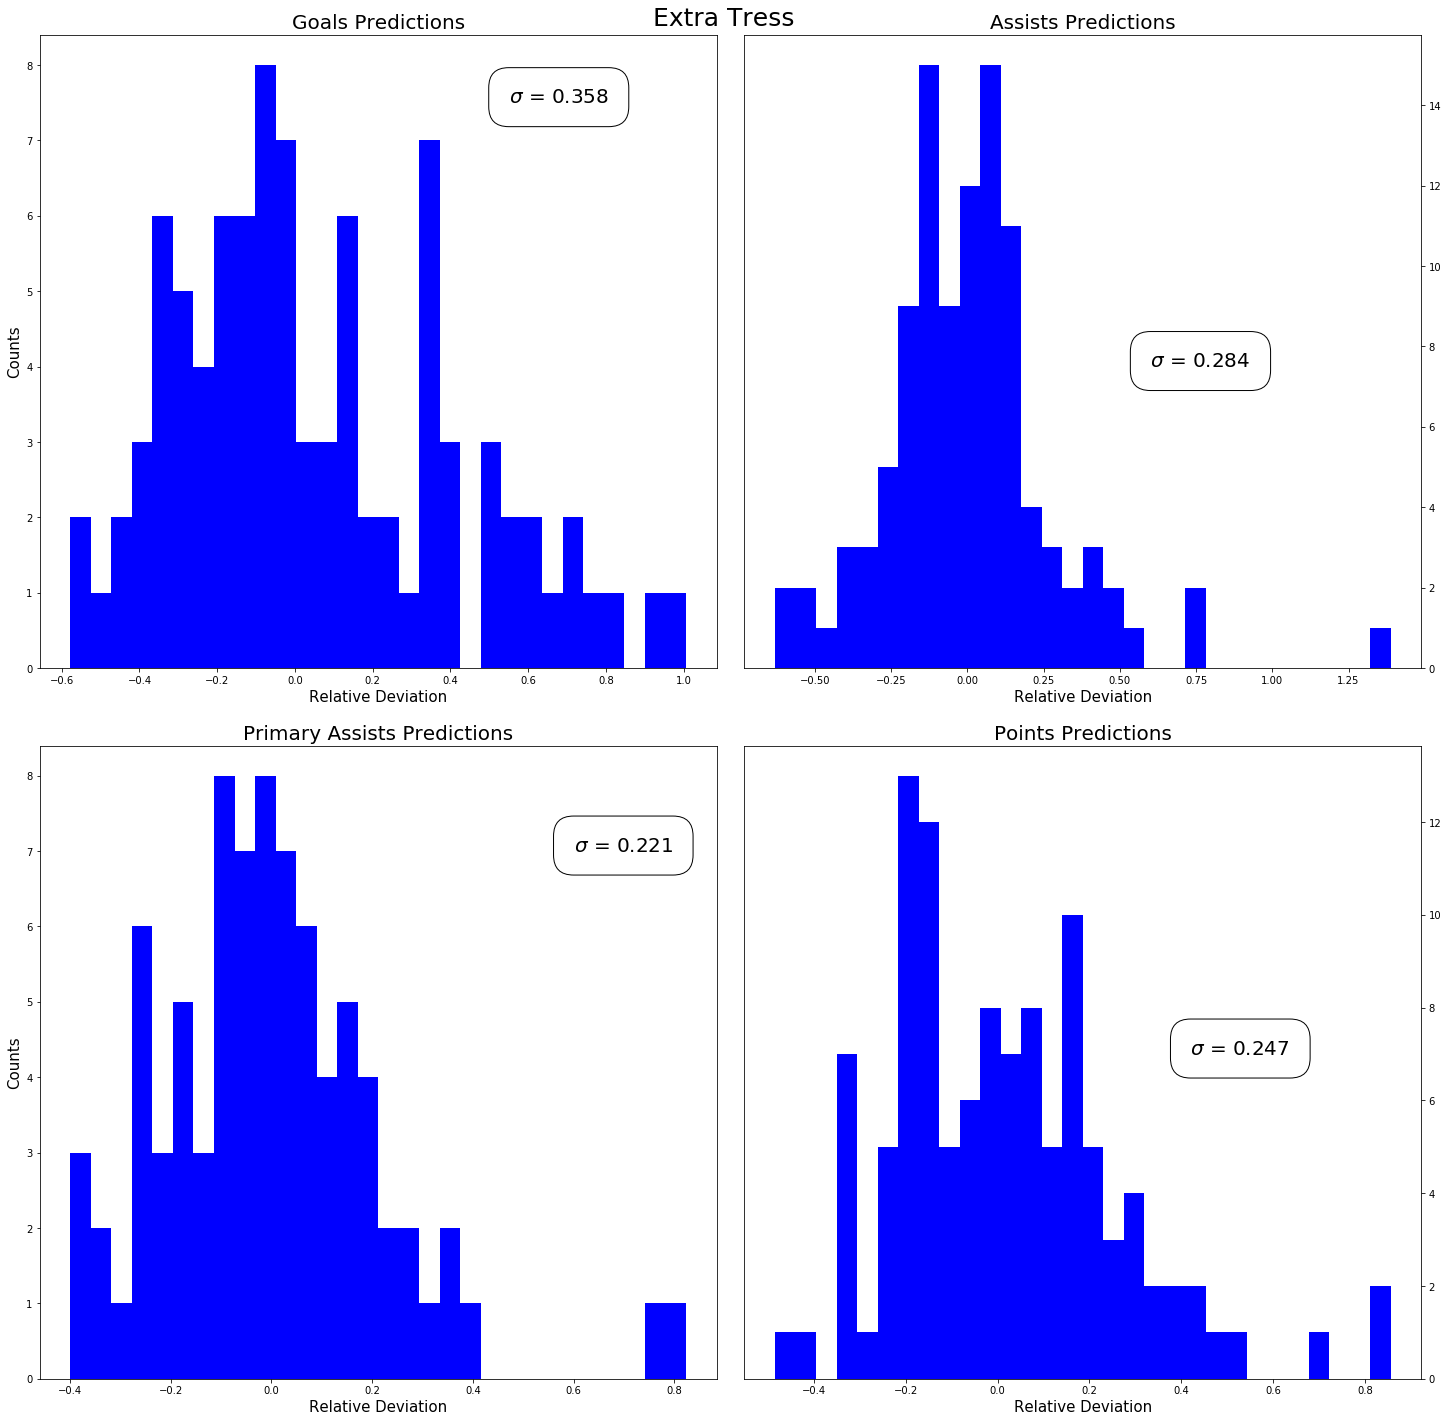

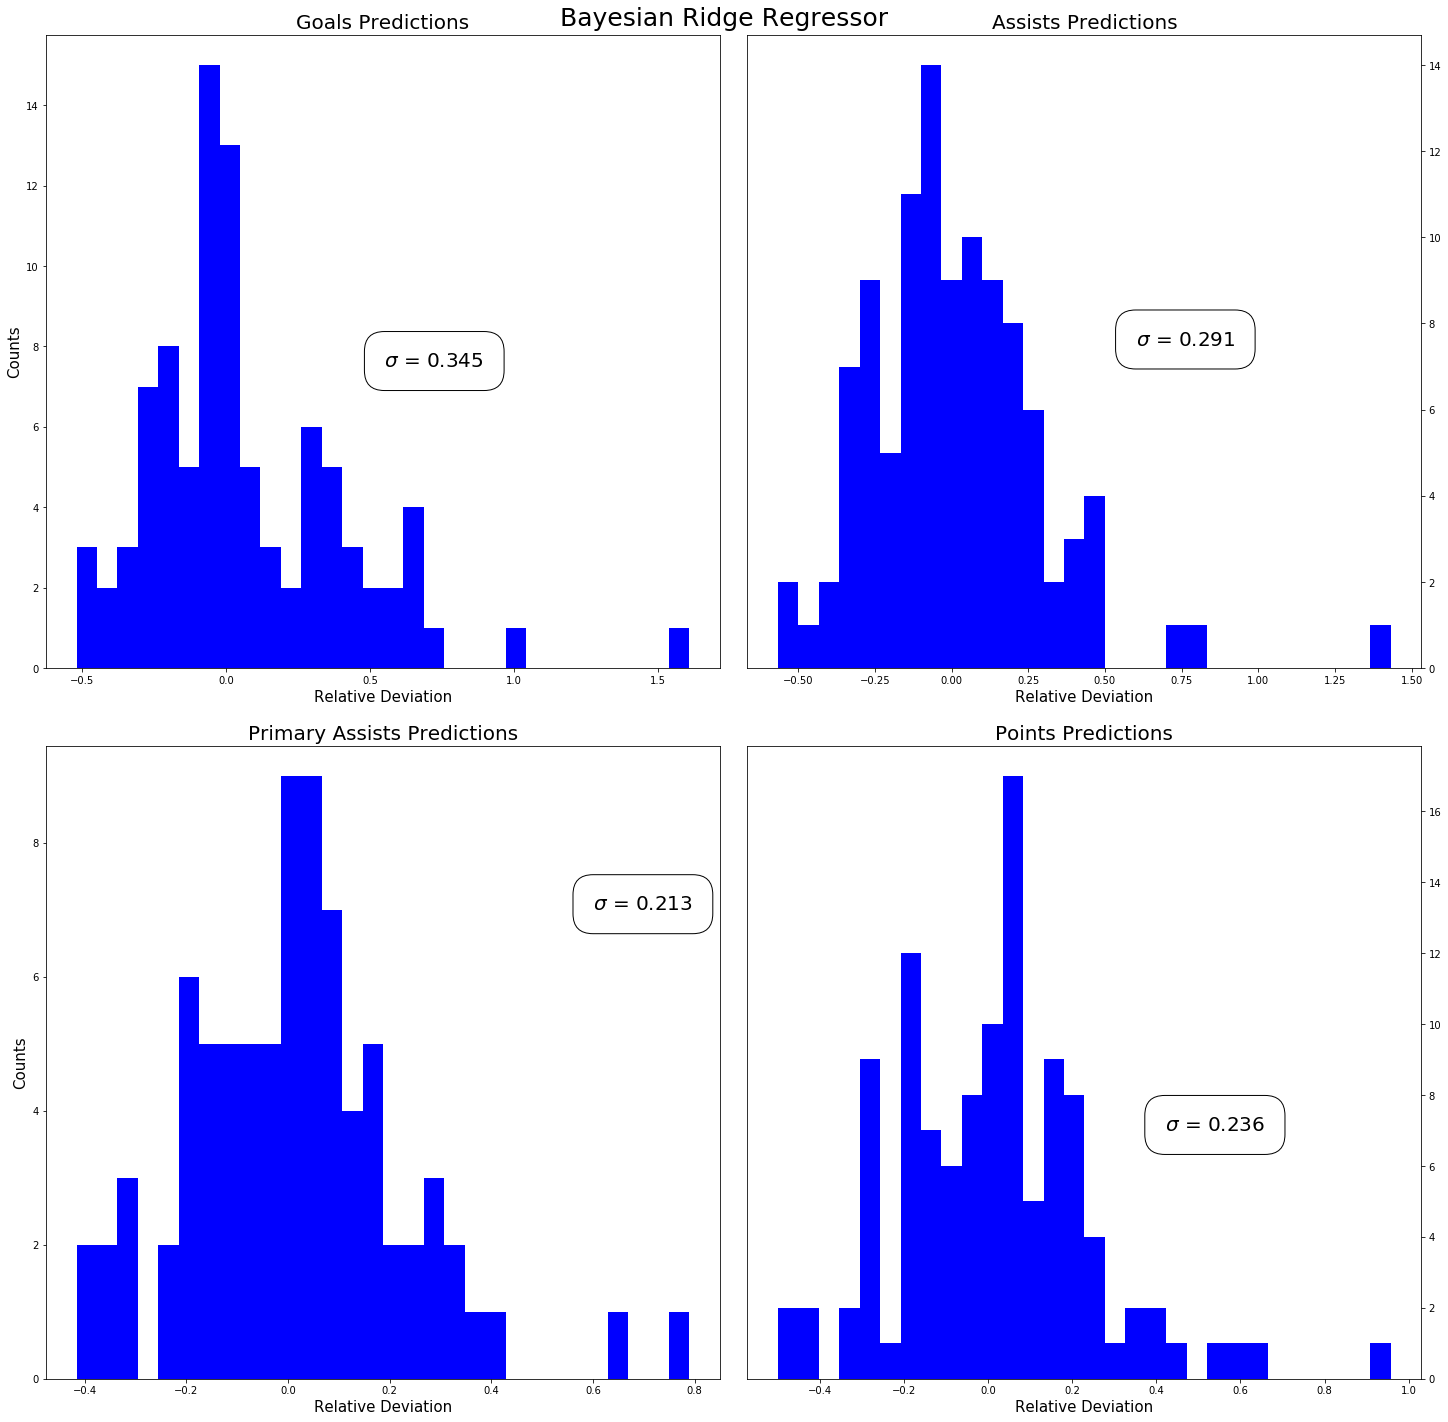

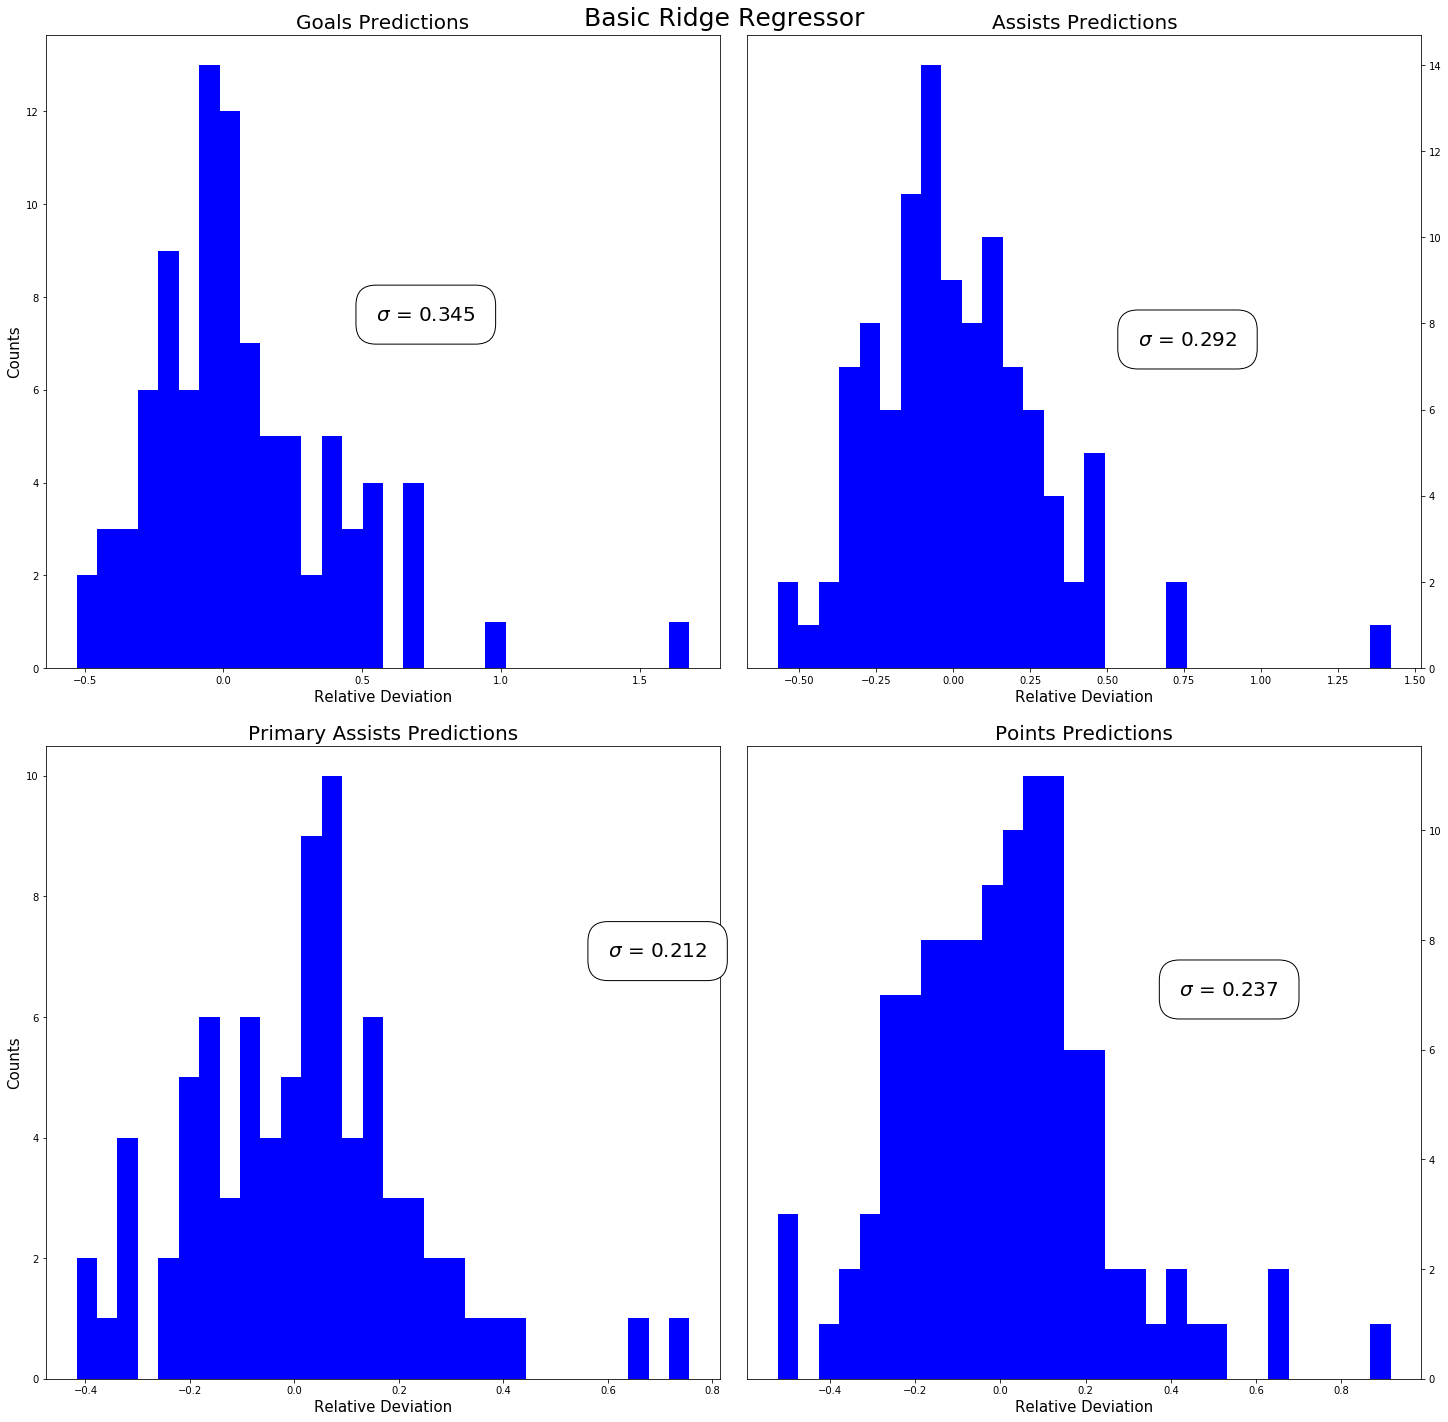

In [22]:

for (model_name,dummy),predictions_raw in zip(Retained_regressors,all_predictions):

    predictions = predictions_raw[:3]+predictions_raw[-1:]
    targets_list = [test_targets_goals, test_targets_assists, test_targets_primary_assists, test_targets_points]
    treshold_list = [5, 7, 5, 10]
    std, deviations = [], []
    for pred, target, treshold in zip(predictions, targets_list, treshold_list) :
        pred.shape=(len(pred),1)
        not_small = np.where(target > treshold)[0]
        deviations.append((pred[not_small] - target[not_small]) / target[not_small])
        std.append(np.std(deviations[-1]))

    fig, ax = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(20,20))
    ax1, ax2, ax3, ax4 = ax.flatten()

    ax1.hist(deviations[0], bins=30,color='b')
    ax1.set_title('Goals Predictions', fontsize=20)
    ax1.set_xlabel('Relative Deviation', fontsize=15)
    ax1.set_ylabel('Counts', fontsize=15)
    ax1.text(0.55, 7.5, '$\sigma$ = {:5.3f}'.format(std[0]), color='black', 
            fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
                      boxstyle='round,pad=1'))

    ax2.hist(deviations[1], bins=30,color='b')
    ax2.yaxis.tick_right()
    ax2.set_title('Assists Predictions', fontsize=20)
    ax2.set_xlabel('Relative Deviation', fontsize=15)
    ax2.text(0.6, 7.5, '$\sigma$ = {:5.3f}'.format(std[1]), color='black', 
            fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
                      boxstyle='round,pad=1'))

    ax3.hist(deviations[2], bins=30,color='b')
    ax3.set_title('Primary Assists Predictions', fontsize=20)
    ax3.set_xlabel('Relative Deviation', fontsize=15)
    ax3.set_ylabel('Counts', fontsize=15)
    ax3.text(0.6, 7, '$\sigma$ = {:5.3f}'.format(std[2]), color='black', 
            fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
                      boxstyle='round,pad=1'))

    ax4.hist(deviations[3], bins=30,color = 'b')
    ax4.yaxis.tick_right()
    ax4.set_title('Points Predictions', fontsize=20)
    ax4.set_xlabel('Relative Deviation', fontsize=15)
    ax4.text(0.42, 7, '$\sigma$ = {:5.3f}'.format(std[3]), color='black', 
            fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
                      boxstyle='round,pad=1'))
    
    #plt.tight_layout()
    fig.suptitle(model_name,fontsize=25)
    plt.show()

In [146]:
predict1[0].shape

(178,)

In [148]:
test_targets_goals.shape

(178, 1)